In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/tras_images" "/content/tras_images"

Mounted at /gdrive


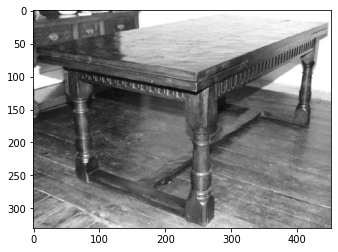

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

DATADIR = "/content/tras_images/test"
CATEGORIES = ["table","sofa","chair"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

**create data set**

In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATADIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9 files belonging to 3 classes.
Using 8 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATADIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9 files belonging to 3 classes.
Using 1 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['chair', 'sofa', 'table']


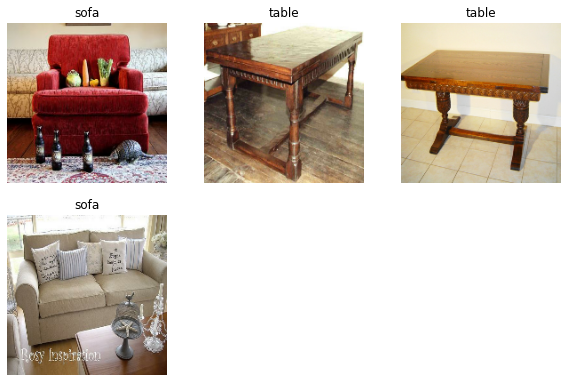

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 180, 180, 3)
(8,)


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9993646


In [12]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.7422 - accuracy: 0.0000e+00 - val_loss: 2.5049 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 302ms/step - loss: 2.0329 - accuracy: 0.3750 - val_loss: 1.2691 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 280ms/step - loss: 1.4777 - accuracy: 0.3750 - val_loss: 0.4091 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 273ms/step - loss: 1.1442 - accuracy: 0.6250 - val_loss: 0.3914 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 276ms/step - loss: 1.0019 - accuracy: 0.3750 - val_loss: 0.5767 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 274ms/step - loss: 0.8769 - accuracy: 0.6250 - val_loss: 0.8472 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 289ms/step - loss: 0.7743 - accuracy: 1.0000 - val_loss: 0.9060 - val_accuracy: 1.0000
Epoch 8/10


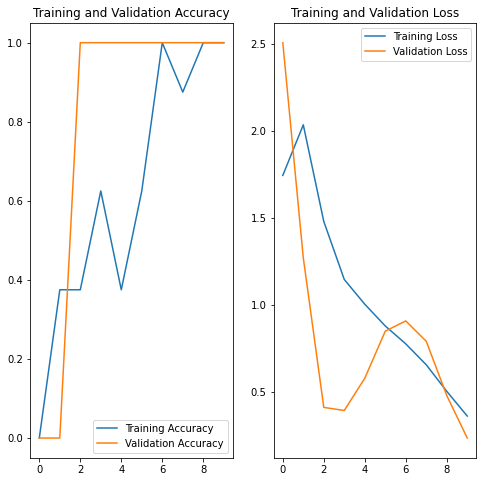

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

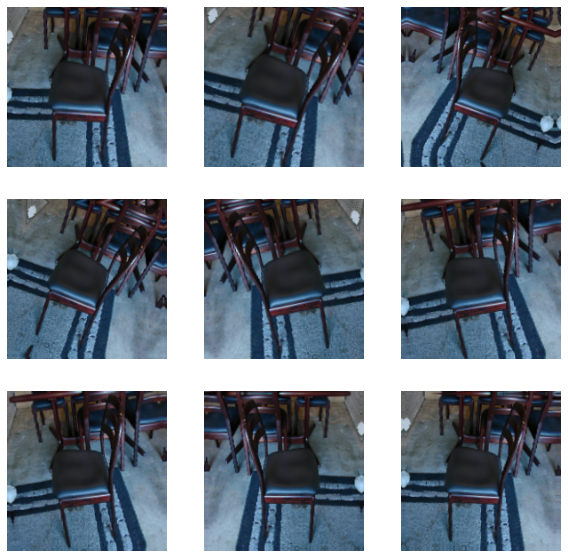

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 1.6155 - accuracy: 0.3750 - val_loss: 1.6570 - val_accuracy: 0.0000e+00
Epoch 2/15
1/1 [==============================] - 0s 325ms/step - loss: 1.0377 - accuracy: 0.3750 - val_loss: 0.8998 - val_accuracy: 0.0000e+00
Epoch 3/15
1/1 [==============================] - 0s 314ms/step - loss: 1.1334 - accuracy: 0.3750 - val_loss: 0.7461 - val_accuracy: 0.0000e+00
Epoch 4/15
1/1 [==============================] - 0s 308ms/step - loss: 1.2949 - accuracy: 0.3750 - val_loss: 0.6804 - val_accuracy: 1.0000
Epoch 5/15
1/1 [==============================] - 0s 324ms/step - loss: 0.9502 - accuracy: 0.5000 - val_loss: 1.0062 - val_accuracy: 0.0000e+00
Epoch 6/15
1/1 [==============================] - 0s 310ms/step - loss: 0.8215 - accuracy: 0.5000 - val_loss: 0.9380 - val_accuracy: 0.0000e+00
Epoch 7/15
1/1 [==============================] - 0s 323ms/step - loss: 0.8174 - accuracy: 0.5000 - val_loss: 0.4778 - val_accuracy: 1.0000
Epo

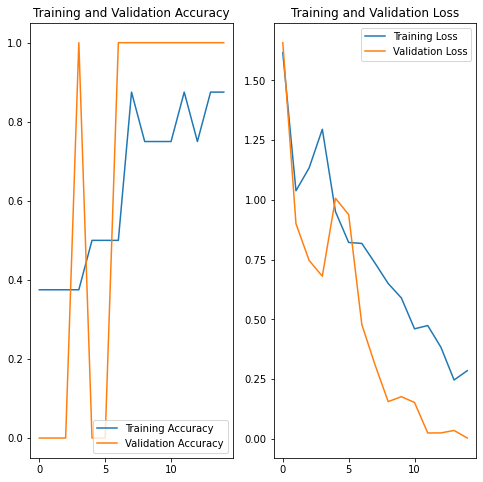

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:

train_path = '/content/tras_images/test/table/00000379.jpg'

img = keras.preprocessing.image.load_img(
    train_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to table with a 99.29 percent confidence.
